# Exploring correlated data with CCM

In [10]:
import numpy as np
import copy
import shap
import pandas as pd
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from sympy.solvers.solveset import linsolve
from sympy import Matrix, simplify, symbols
from graphviz import Digraph

from lib.models import CCM, CBM, MLP, LambdaNet
from lib.train import train_step_standard, train_step_xyz, train
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c
from lib.utils import dfs_freeze

# Linear regression with correlated data

Given $X_1 = Y + n_1$, $X_2 = Y + n_2$ where $n_1 \sim N(0, s_1)$ and $n_2 \sim N(0, s_2)$, I'd expect the linear coefficient to add up to $1$,
but it doesn't for a least square regression setting.

$$min_\theta \mathbb{E}_{(x, y)} (y-\theta^T x)^2$$ 

taking derivative on both sides and set to $0$ simplies to 

$$\left[\begin{matrix}\mathbb{E}(Y^2) + s^{2}_{1} & \mathbb{E}(Y^2) & \mathbb{E}(Y)\\\mathbb{E}(Y^2) & \mathbb{E}(Y^2) + s^{2}_{2} & \mathbb{E}(Y)\\\mathbb{E}(Y) & \mathbb{E}(Y) & 1\end{matrix}\right] \boldsymbol{\theta} = \left[\begin{matrix}\mathbb{E}(Y^2)\\\mathbb{E}(Y^2)\\\mathbb{E}(Y)\end{matrix}\right]$$

In [2]:
s_y2, s_y, s_s12, s_s22 = symbols('\mathbb{E}(Y^2) \mathbb{E}(Y) s_1^2 s_2^2')

A = Matrix([[s_y2 + s_s12, s_y2, s_y], [s_y2, s_y2 + s_s22, s_y], [s_y, s_y, 1]])
b = Matrix([[s_y2], [s_y2], [s_y]])

result = linsolve((A, b))
result

FiniteSet(((\mathbb{E}(Y)**2*s_2^2 - \mathbb{E}(Y^2)*s_2^2)/(\mathbb{E}(Y)**2*s_1^2 + \mathbb{E}(Y)**2*s_2^2 - \mathbb{E}(Y^2)*s_1^2 - \mathbb{E}(Y^2)*s_2^2 - s_1^2*s_2^2), (\mathbb{E}(Y)**2*s_1^2 - \mathbb{E}(Y^2)*s_1^2)/(\mathbb{E}(Y)**2*s_1^2 + \mathbb{E}(Y)**2*s_2^2 - \mathbb{E}(Y^2)*s_1^2 - \mathbb{E}(Y^2)*s_2^2 - s_1^2*s_2^2), -\mathbb{E}(Y)*s_1^2*s_2^2/(\mathbb{E}(Y)**2*s_1^2 + \mathbb{E}(Y)**2*s_2^2 - \mathbb{E}(Y^2)*s_1^2 - \mathbb{E}(Y^2)*s_2^2 - s_1^2*s_2^2)))

The above is the solution (coefficient for $x_1$, $x_2$, and the bias term) to the system: Note that denominators are the same, also note that coefficient of the first feature is larger when the second feature has larger noise (e.g. $\theta_1 / \theta_2 = s_2^2 / s_1^2$). However, the sum of $1 - (\theta_1 + \theta_2) \neq 0$, which is suprising: as shown below:

In [3]:
theta1, theta2, theta3 = result.args[0]
simplify(1- (theta1 + theta2))

s_1^2*s_2^2/(-\mathbb{E}(Y)**2*s_1^2 - \mathbb{E}(Y)**2*s_2^2 + \mathbb{E}(Y^2)*s_1^2 + \mathbb{E}(Y^2)*s_2^2 + s_1^2*s_2^2)

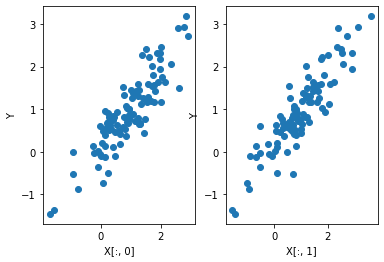

In [4]:
# the empirical result is most prominant with s1=5, s2=1
n = 1000
d = 2
s1 = 0.5
s2 = 0.4

Y = torch.randn(n) + 1
x1 = Y + s1 * torch.randn(n)
x2 = Y + s2 * torch.randn(n)
X = torch.vstack([x1, x2]).T

for i in range(d):
    plt.subplot(1, 2, i+1)
    plt.scatter(X.numpy()[:100, i], Y.numpy()[:100])
    plt.xlabel(f"X[:, {i}]")
    plt.ylabel("Y")
plt.show()

epoch  59: loss 1.473e-01
epoch 119: loss 1.285e-01
epoch 179: loss 1.191e-01
epoch 239: loss 1.122e-01
epoch 299: loss 1.070e-01
epoch 359: loss 1.031e-01
epoch 419: loss 1.001e-01
epoch 479: loss 9.774e-02
epoch 539: loss 9.593e-02
epoch 599: loss 9.452e-02


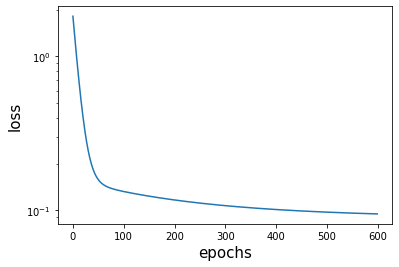

In [5]:
def standard_model(loader_xy, d, n_epochs=10, report_every=1, plot=True):
    # regular model
    net = MLP([d, 1])

    # train
    opt = optim.SGD(net.parameters(), lr=0.005)
    # opt = optim.SGD(net.parameters(), lr=0.001)
    # opt = optim.Adam(net.parameters())
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=lambda o, y: F.mse_loss(o.view(-1), y))
    if plot: plot_log(log)
    return net

bs = n # gradient descent
n_epochs = 600

loader_xy = DataLoader(TensorDataset(X, Y), batch_size=bs, shuffle=True) # regular dataset
net = standard_model(loader_xy, d, n_epochs=n_epochs, report_every=n_epochs//10)

In [6]:
print(net.classifier[0].weight)
print(net.classifier[0].weight.sum())
print(net.classifier[0].bias)

Parameter containing:
tensor([[0.2456, 0.6710]], requires_grad=True)
tensor(0.9166, grad_fn=<SumBackward0>)
Parameter containing:
tensor([0.0816], requires_grad=True)


In [7]:
a = 1 # E(y^2)
b = s1**2 # E(s1^2)
c = s2**2 # E(s2^2)

print('theta 1', a*c / (b*c + a*b + a*c))
print('theta 2', a*b / (b*c + a*b + a*c))
print('t1 + t2', (a*b + a*c)/ (b*c + a*b + a*c))

print(b*c / (b*c + a*b + a*c))

theta 1 0.35555555555555557
theta 2 0.5555555555555555
t1 + t2 0.9111111111111111
0.08888888888888889


            0         1        O0
186 -0.248234  0.020702  0.034483
787  0.802839  0.219321  0.425923
730  0.332112  0.694498  0.629130
716  1.256521  0.861627  0.968330
474  1.015060  1.071641  1.049934
476  1.208996  1.101815  1.117815
187  0.637616  1.324187  1.126674
532  1.459116  1.363762  1.355011
904  1.870887  2.381780  2.139215
33   2.800814  3.123574  2.865354
Explaining O0


  0%|          | 0/10 [00:00<?, ?it/s]

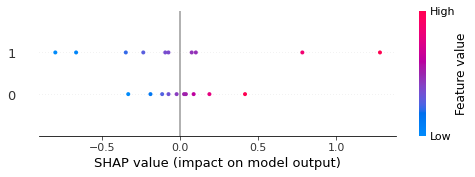

In [8]:
shap_x = pd.DataFrame(X.numpy()).sample(10)
shap_net_x(net, shap_x, bs, instance_idx=None, output_name="O", decimal=10)

# Why does concept credible model make sense even when concepts may be confounded

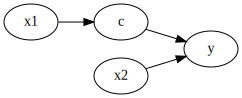

In [13]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('c')
dot.node('y')

dot.edge('1', 'c')
dot.edge('c', 'y')
dot.edge('2', 'y')
dot.graph_attr['rankdir']='LR'
dot

Assume $X_2$ is actually a shortcut and that each edge is corrupted by some independent zero mean noise:

e.g., $C = Y + N_c$, $X_1 = C + N_{X_1}$, $X_2 = Y + N_{X_2}$ where $N_v$ are the independent noises for a variable $v$.

Now assume we fit a least square linear regression to the model (from $X_1$, $X_2$ to $Y$), using the conclusion from previous experiment, we have

$$\theta_{X_1} / \theta_{X_2} = \mathbb{v}(N_{X_2}) / (\mathbb{v}(N_{X_1})  + \mathbb{v}(N_C)))$$

However, if we restrict the model bottlenecked by concept $c$ (special case of CCM), we'd have

$$\theta_{X_1} / \theta_{X_2} = (\mathbb{v}(N_{X_2}) + \mathbb{v}(N_C)) / \mathbb{v}(N_{X_1})$$

This means the classifier depends much less on $X_2$.

In this case, however, if $N_2$ is indeed smaller than other noises, we would expect the CBM to perform worse on the dataset, but better in deployment. This does call for a domain specific judgement.